In [2]:
# Import things we'll need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from scipy.fft import fft, fftshift, fftfreq
from IPython.display import HTML

%matplotlib inline

# Bessel functions for fibre mode shapes
In order to find the mode profile in a step-index fibre, we need to solve the wave equation in cylindrical polar coordinates.  In the lecture notes, this is rendered as:
$$
\left(\nabla^2 - {n^2 \over c^2}\partial_t^2\right)\mathbf{E} 
= \left({1\over r}\partial_r \left[r\partial_r\right] + {1 \over r^2}\partial_\phi^2 - \beta^2 + {n^2 \omega^2 \over c^2}\right)\mathbf{E} 
= 0
$$
We can postulate a separable solution here, i.e. $\mathbf{E}=\hat{\mathbf{x}}R(r)\Phi(\phi)e^{i(\beta z - \omega t)}$, and substitute in to the equation above.  After a little rearrangement, we get:
$$
{r\partial_r \left[r\partial_r R(r)\right]\over R(r)} + \left({n^2 \omega^2 \over c^2} - \beta^2 \right)r^2
= {\partial_phi \Phi(\phi) \over \Phi(\phi)} = l^2
$$
Where $l^2$ is the name given to the constant that both sides must equal (because one depends only on $r$ and the other only on $\phi$).  This has a simple solution in $\phi$:
$$\Phi(\phi) = e^{il\phi}$$
The solution in $r$ is more complicated.  We can define $\kappa^2={\omega^2n^2\over c^2} - \beta^2$ as before, and multiply through by $R$ to get:
$$
\left(r^2\partial^2_r + r\partial_r + (\kappa^2r^2 - l^2)\right)R = 0
$$
This is Bessel's equation.  The solutions to this are know as "Bessel Functions" and they come in different "kinds" known as $J$, $Y$, $I$, and $K$.  

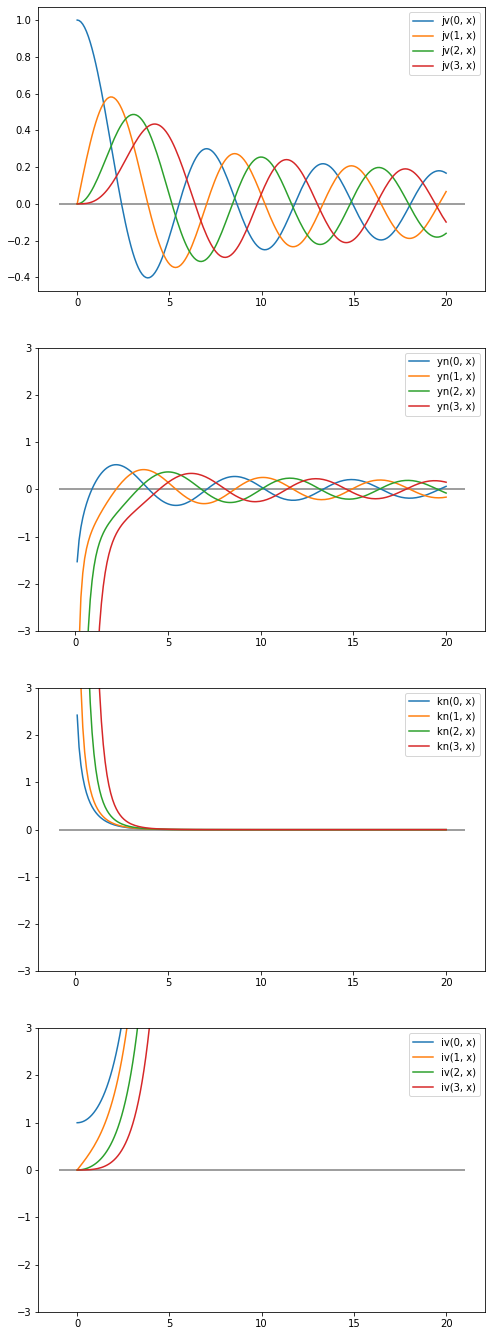

In [15]:
from scipy.special import jv, yn, kn, iv
f, axes = plt.subplots(4, 1, figsize=(8,24))
for ax, func in zip(axes, [jv, yn, kn, iv]):
    xx = np.linspace(0,20,200)
    for order in range(4):
        yy = func(order, xx)
        ax.plot(xx, yy, label=f"{func.__name__}({order}, x)")
    ax.hlines(0, *ax.get_xlim(), color="gray")
    ax.legend()
    ax.set_ylim(max(-3, ax.get_ylim()[0]), min(3, ax.get_ylim()[1]))

It's worth noting that there are really only two kinds of Bessel function; the functions are valid for complex arguments, and the "modified" bessel functions $K$ and $I$ are more or less the regular ones, with imaginary arguments.  There's a nice parallel there between the oscillatory $e^{i\kappa y}$ terms and the decaying $e^{\gamma y}$ terms for a slab waveguide.

Bessel's equation is usually defined:
$$
\left(x^2\partial_x + x\partial_x (x^2 - \alpha^2)\right)y = 0
$$
So, we see that the order of our Bessel function must be $\alpha$ - but note the $\kappa$: this simply scales things (try substituting $x=\kappa r$ and see what happens).  The solutions to our wave equation must thus be $J_l(\kappa r)$ in the core (oscillatory solutions) and $K_l(\kappa r)$ in the cladding (decaying).

# Boundary conditions
As with the slab waveguide, the boundary conditions are that the gradient of the field, and the value of the field, are continuous at the boundary (whether it's $E$ or $D$ that's continuous makes little difference as the refractive index contrast is generally very small).  This leads to the "characteristic equation":
$$ \kappa {J_{l-1}(\kappa a) \over J_l(\kappa a)} = -\gamma {K_{l-1}(\gamma a) \over K-l(\gamma a)} $$
where $\gamma$ is defined as $\gamma^2 = \beta^2 - \omega^2n_0^2/c^2$.

I'll just solve this numerically, by sweeping $\beta$ through the full range of allowable values: $n_o\omega/c$ to $n_1\omega/c$.

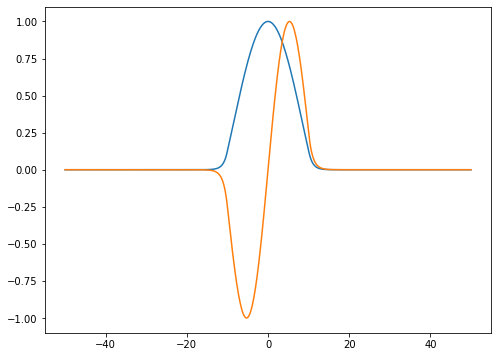

In [119]:
def find_betas(l, core_radius, core_n, cladding_n, vacuum_wavevector):
    """Numerically find the propagation constant that matches boundary conditions"""
    betas = np.linspace(core_n - 0.0001, cladding_n + 0.0001, 1000)*vacuum_wavevector
    kappas = np.sqrt(vacuum_wavevector**2 * core_n**2 - betas**2)
    gammas = np.sqrt(betas**2 - vacuum_wavevector**2 * cladding_n**2)
    distances = (
        kappas * jv(l-1, kappas * core_radius) / jv(l, kappas*core_radius)
        + gammas * kn(l-1, gammas * core_radius) / kn(l, gammas*core_radius)
    )
    sign_flips = np.argwhere(np.sign(distances[1:]) != np.sign(distances[:-1]))
    zero_crossings = []
    for i in sign_flips:
        i = i[0]
        try:
            if np.abs(distances[i+1] - distances[i]) < np.abs(distances[i+2] - distances[i-1]):
                zero_crossings.append(i)
        except IndexError:
            continue
    return betas[zero_crossings]

def R(r, l, p, core_radius, core_n, cladding_n, vacuum_wavevector):
    """A piecewise-continuous function for the mode profile in a step index fibre"""
    beta = find_betas(l, core_radius, core_n, cladding_n, vacuum_wavevector)[p]
    kappa = np.sqrt(vacuum_wavevector**2 * core_n**2 - beta**2)
    gamma = np.sqrt(beta**2 - vacuum_wavevector**2 * cladding_n**2)
    #print(f"beta/k:{beta/vacuum_wavevector}, kappa:{kappa/vacuum_wavevector}, gamma: {gamma/vacuum_wavevector}")
    core_field = jv(l, kappa*r)/jv(l, kappa*core_radius)
    cladding_field = kn(l, gamma*r)/kn(l, gamma*core_radius)
    return np.where(r<core_radius, core_field, cladding_field)

fig, axes = plt.subplots(1,1, figsize=(8,6))
xx = np.linspace(-50, 50, 500)
for l in range(2):
    for p in range(1):
        yy = R(np.abs(xx), l, p, 10, 1.5, 1.48, 2*np.pi/1.5)*np.sign(xx)**l
        yy /= np.max(abs(yy))
        axes.plot(xx, yy)

# 2D Plots
It wouldn't be fair to finish without showing some 2D mode profiles.  This is where we put together the Bessel function in $r$ with the exponential phase in $\phi$.  As it's quite hard to plot that, it's conventional to pair up the complex exponentials into sine and cosine functions.

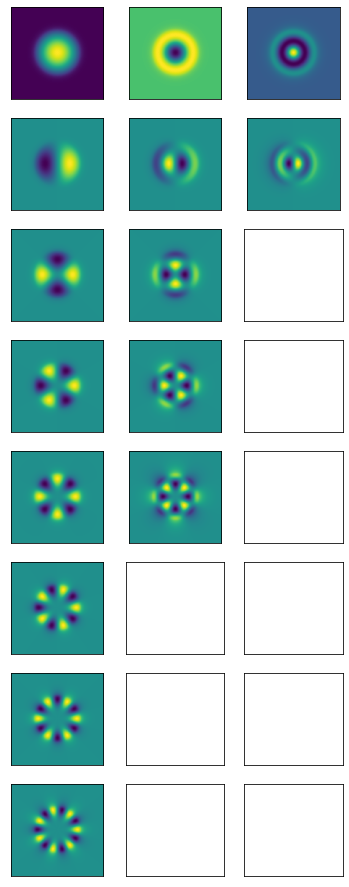

In [131]:
fig, axes = plt.subplots(8, 3, figsize=(6,16))
a = 10
w = 2*a
wavelength = 1.5
n0 = 1.48
n1 = 1.5

xx = np.linspace(-w, w, 500)[:, np.newaxis]
yy = np.linspace(-w, w, 500)[np.newaxis, :]
rr = np.sqrt(xx**2 + yy**2)
phi = np.arctan2(xx, yy)
for l in range(axes.shape[0]):
    for p in range(axes.shape[1]):
        try:
            mode_shape = R(rr, l, p, a, n1, n0, 2*np.pi/wavelength)*np.cos(l*phi)
            axes[l,p].imshow(mode_shape)
        except IndexError:
            pass
        axes[l,p].get_xaxis().set_visible(False)
        axes[l,p].get_yaxis().set_visible(False)

In [129]:
# Check we haven't missed any modes - there should be no valid beta values for the next l value:
find_betas(8, a, n1, n0, 2*np.pi/wavelength)

array([], dtype=float64)